In [1]:
%pip install -qU langchain-together

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
# Add this at the beginning of your notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from agent_hub.orchestrator.orchestrator import Orchestrator, OrchestratorInput
from agent_hub.browser.browser_agent import BrowserUse
from agent_hub.cli.cli_agent import CLIAgent
from agent_hub.web_searcher.web_searcher import WebSearcher
from agent_hub.graph import State
from agent_hub.front_llm import FrontLLM
browse_use = BrowserUse()
cli_agent = CLIAgent()
web_searcher = WebSearcher()
agents = [browse_use, cli_agent, web_searcher]
orchestrator = Orchestrator(available_agents=agents)
front_llm = FrontLLM()
await orchestrator.setup()

def next_step(state: State):
    next_agent_name = state["next_agent_name"]
    if next_agent_name is not None:
        return next_agent_name
    else:
        return front_llm.name

def is_computer_interaction_required(state: State):
    is_computer_interaction_required = state["is_computer_interaction_required"]
    if is_computer_interaction_required:
        return orchestrator.name
    else:
        return END

graph_builder = StateGraph(State)

graph_builder.add_node(orchestrator.name, orchestrator)
graph_builder.add_node(front_llm.name, front_llm)
graph_builder.add_edge(START, front_llm.name)
graph_builder.add_conditional_edges(front_llm.name, is_computer_interaction_required)
for agent in agents:
    graph_builder.add_node(agent.name, agent)
    graph_builder.add_edge(agent.name, orchestrator.name)

graph_builder.add_conditional_edges(orchestrator.name, next_step)


graph = graph_builder.compile()

Setting up the orchestrator
Setting up agent: BrowserUse
BrowserUse is ready
Setting up agent: CLIAgent
CLIAgent is setting up
Setting up agent: WebSearcher
WebSearcher agent is setting up
Orchestrator setup complete


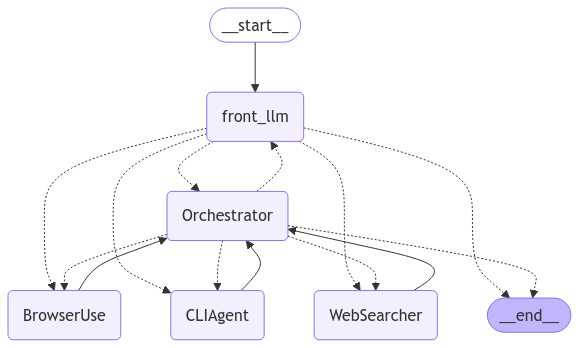

In [23]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [24]:
from pathlib import Path
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod

# Create docs directory if it doesn't exist
Path("docs").mkdir(exist_ok=True)

# Generate and save the Mermaid diagram
png_data = graph.get_graph().draw_mermaid_png(
    draw_method=MermaidDrawMethod.API,
    background_color="white",
    padding=10
)

# Save the PNG data to a file
output_path = "docs/mermaid_graph.png"
with open(output_path, "wb") as f:
    f.write(png_data)

In [13]:
from langchain_core.messages import HumanMessage
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [HumanMessage(content=user_input)], "user_input": user_input}):
        for value in event.values():
            print(value)
            print("Assistant:", value["messages"][-1].content)

def invoke_graph(user_input: str):
    return graph.invoke({"messages": [HumanMessage(content=user_input)], "user_input": user_input})



In [22]:
invoke_graph("What is the time now in Paris?")

Inside Orchestrator, current plan: None
************************************************************
Executing task: Search flights
by calling agent: BrowserUse
with input: {'query': 'search flights from Morocco to Paris'}
************************************************************
Sync BrowseUse is calling the available agents for the task: query='search flights from Morocco to Paris'
BrowseUse has finished the task: query='search flights from Morocco to Paris'
Inside Orchestrator, current plan: {
    "tasks": [
        {
            "name": "Search flights",
            "description": "Find available flights from Morocco to Paris",
            "execution_agent_name": "BrowserUse",
            "task_status": "pending"
        },
        {
            "name": "Select flight",
            "description": "Choose the best flight option based on price and schedule",
            "execution_agent_name": "BrowserUse",
            "task_status": "pending"
        },
        {
            "nam

{'plan': OrchestratorPlan(tasks=[Task(name='Search flights', description='Find available flights from Morocco to Paris', execution_agent_name='BrowserUse', task_status=<TaskStatus.PENDING: 'pending'>), Task(name='Select flight', description='Choose the best flight option based on price and schedule', execution_agent_name='BrowserUse', task_status=<TaskStatus.PENDING: 'pending'>), Task(name='Book flight', description='Enter passenger information and complete the booking process', execution_agent_name='CLIAgent', task_status=<TaskStatus.PENDING: 'pending'>)], goal='Book a flight to Paris from Morocco', current_task_index=2, is_completed=True),
 'last_task_status': <TaskStatus.SUCCESS: 'success'>,
 'last_task_output': 'CLIAgent has finished the task: Enter passenger information and complete the booking process',
 'next_agent_input': None,
 'next_agent_name': None,
 'messages': [HumanMessage(content='Can you book a flight to Paris from Morocco?', additional_kwargs={}, response_metadata={},

In [4]:
from agent_hub.browser.browser_agent import BrowserUse
browse_use = BrowserUse()
await browse_use.setup()

# Now you can use it in your graph or directly
result = await browse_use.__acall__({
    "next_agent_input": {
        "query": "Find a one-way flight from Bali to Oman on 12 January 2025 on Google Flights"
    }
})

BrowserUse is ready
Async BrowserUse is calling the available agents for the task: query='Find a one-way flight from Bali to Oman on 12 January 2025 on Google Flights'
INFO     [agent] 🚀 Starting task: Find a one-way flight from Bali to Oman on 12 January 2025 on Google Flights
INFO     [agent] 
📍 Step 1
WARNING  [browser] Page load failed, continuing...
ERROR    [agent] ❌ Result failed 1/5 times:
 Unexpected error: 
Stacktrace:
Traceback (most recent call last):
  File "c:\Users\Soufiane.DAHIMI\Projects\Nexus Agents\.venv\Lib\site-packages\browser_use\agent\service.py", line 118, in step
    state = await self.controller.browser.get_state(use_vision=self.use_vision)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Soufiane.DAHIMI\Projects\Nexus Agents\.venv\Lib\site-packages\browser_use\browser\service.py", line 503, in get_state
    session = await self.get_session()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Soufiane.DAHIM

In [ ]:
import requests
import json

SERPER_API_KEY=8104f6e89253180fefebf1f58471b8767f4080ee
JINA_API_KEY=jina_11f89a2aa966482498588c1dba1b93cccPFEIYXl3IdmkKNLyyDVFhl2g8-J

def search_web(
        query: str, type: str = "search", **params
    ) -> list[dict]:
        url = f"https://google.serper.dev/{type}"
        headers = {
            "X-API-KEY": api_key,
            "Content-Type": "application/json",
        }

        payload_data = {"q": query}
        payload_data.update(params)
        payload = json.dumps(payload_data)
        response = requests.request("POST", url, headers=headers, data=payload)
        results = response.json()
        results = results["organic"]
        # rename "link" key to "url"
        for result din results:
            result["url"] = result.pop("link")
        return results
    

def __init__(self, model="jina-reranker-v2-base-multilingual", top_n=10):
        super().__init__()
        self.model = model
        self.top_n = top_n

    def rerank_documents(self, query, docs):
        url = "https://api.jina.ai/v1/rerank"

        headers = {
            "Content-Type": "application/json",
            "Authorization": "Bearer " + configurations["JINA_API_KEY"],
        }
        documents = [doc["content"] for doc in docs]
        payload = {
            "model": self.model,
            "query": query,
            "top_n": self.top_n,
            "documents": documents,
        }

        response = requests.post(url, headers=headers, json=payload)

        if response.status_code == 200:
            results = response.json()["results"]
            indices = [
                result["index"] for result in results
            ]  # if result["relevance_score"] > 0.1
            return [docs[index] for index in indices]
        else:
            raise Exception(f"Error: {response.status_code}, {response.text}")
        
llm = get_llm()



In [9]:
from agent_hub.web_searcher.web_searcher import WebSearcher
web_searcher = WebSearcher()
await web_searcher.setup()

# Now you can use it in your graph or directly
result = await web_searcher.__acall__({
    "next_agent_input": {
        "query": "how is the weather in Paris today?"
    }
})

WebSearcher agent is setting up


In [19]:
from evaluation.reward_models.web_search_reward_model import WebSearchRewardModel
from evaluation.metrics.memory_efficiency import measure_memory
from evaluation.metrics.latency import measure_latency
import json
import time
web_searcher_benchmark = json.load(open("evaluation/benchmarks_datasets/web_search_benchmark.json"))
web_searcher_reward_model = WebSearchRewardModel()
dataset = web_searcher_benchmark["benchmark_data"][:5]

print("Benchmarking web searcher...")
print("--------------------------------")
print("Memory usage:")
avg_current_memory = []
avg_peak_memory = []
for query in dataset:
    result, current_memory, peak_memory = measure_memory(web_searcher.__call__)({
        "next_agent_input": {
            "query": query["query"]
        }
    })
    avg_current_memory.append(current_memory)
    avg_peak_memory.append(peak_memory)
    time.sleep(1)

print(f"Average current memory: {sum(avg_current_memory) / len(avg_current_memory)} MB")
print(f"Average peak memory: {sum(avg_peak_memory) / len(avg_peak_memory)} MB")

print("--------------------------------")
print("Latency:")
avg_latency = []
for query in dataset:
    result, latency = measure_latency(web_searcher.__call__)({
        "next_agent_input": {
            "query": query["query"]
        }
    })
    avg_latency.append(latency)
    time.sleep(1)

print(f"Average latency: {sum(avg_latency) / len(avg_latency)} seconds")

print("--------------------------------")
print("Quality:")
scores = []
for query in dataset:
    result = web_searcher.__call__({
        "next_agent_input": {
            "query": query["query"]
        }
    })
    score, reason = web_searcher_reward_model.get_reward(query["query"], result, query["expected_answer"])
    scores.append(score)

print(f"Average Quality score: {sum(scores) / len(scores)}")




Benchmarking web searcher...
--------------------------------
--------------------------------
Reward:
INFO     [groq._base_client] Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO     [groq._base_client] Retrying request to /openai/v1/chat/completions in 14.000000 seconds
INFO     [groq._base_client] Retrying request to /openai/v1/chat/completions in 12.000000 seconds
INFO     [groq._base_client] Retrying request to /openai/v1/chat/completions in 10.000000 seconds
INFO     [groq._base_client] Retrying request to /openai/v1/chat/completions in 13.000000 seconds
Average score: 0.78
